# Putting Data and Fitting Models


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

contingency_table = np.array([
    [2.1, 6.8, 8.4, 1.4, 14.6, 7.9, 4.8],
    [1.7, 8.1, 8.4, 1.4, 12, 3.7, 4.5],
    [14.4, 14.8, 27, 30.9, 36.5, 36.4, 31.4],
    [57.4, 62.4, 37.4, 63.3, 65.5, 65.6, 59.8],
    [66.2, 81.7, 53.3, 80.7, 79.7, 80.8, 82.4],
    [75.2, 94, 74.3, 87.9, 93.3, 87.8, 80.5],
    [4.1, 10.2, 10.7, 5.5, 18.1, 11.4, 6.1]
]
)

num_schools = contingency_table.shape[0]
num_periods = contingency_table.shape[1]

matrix = np.zeros((num_schools + num_periods + 1, num_schools * num_periods), dtype=int)

for school in range(num_schools):
    for period in range(num_periods):
        index = school * num_periods + period
        matrix[school, index] = 1  
        matrix[num_schools + period, index] = 1  
        matrix[-1, index] = contingency_table[school, period]  

column_headers = [f'School{i}' for i in range(num_schools)] + [f'Period{j}' for j in range(num_periods)] + ['frequency_count']
df = pd.DataFrame(matrix.T, columns=column_headers)

X = df.iloc[:, :-1]
y = df['frequency_count']

X_poisson = sm.add_constant(X)

poisson_model = sm.GLM(y, X_poisson, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

X_neg_binomial = sm.add_constant(X)

neg_binomial_model = sm.GLM(y, X_neg_binomial, family=sm.families.NegativeBinomial())
neg_binomial_results = neg_binomial_model.fit()




/Users/praveenkumar/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


# Prediction, Model Residuals, and Custom Boxplot's defn

In [2]:
poisson_predictions = poisson_results.predict(X_poisson)

poisson_predictions_rounded = np.round(poisson_predictions)

neg_binomial_predictions = neg_binomial_results.predict(X_neg_binomial)
neg_binomial_predictions_rounded = np.round(neg_binomial_predictions)

poisson_predicted_contingency_table = poisson_predictions_rounded.values.reshape((num_schools, num_periods))
neg_binomial_predicted_contingency_table = neg_binomial_predictions_rounded.values.reshape((num_schools, num_periods))


poisson_flatten=(poisson_predicted_contingency_table-contingency_table).flatten()
n_Binomial_flatten= (neg_binomial_predicted_contingency_table-contingency_table).flatten()






import matplotlib.pyplot as plt
import numpy as np

def custom_boxplot(data, inner_percentage=50 , fill_color='lightgray', ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    lower_limit = (100 - inner_percentage) / 2
    upper_limit = 100 - lower_limit
    custom_percentiles = [lower_limit, upper_limit]
    custom_limits = np.percentile(data, custom_percentiles)


    w1 = custom_limits[0] - 1.5 * (custom_limits[1]-custom_limits[0])
    w2 = custom_limits[1] + 1.5 * (custom_limits[1]-custom_limits[0])

    
    ax.vlines(custom_limits[0], 0.8, 1.2, color='black', linewidth=1)
    ax.vlines(custom_limits[1], 0.8, 1.2, color='black', linewidth=1)
     
    ax.fill_betweenx([0.8, 1.2], custom_limits[0], custom_limits[1], color=fill_color)

    
    ax.hlines([0.8, 1.2], custom_limits[0], custom_limits[1], color='black', linewidth=1)

    median = np.median(data)
    ax.vlines(median, .8, 1.2, color='red', linewidth=1)



    noise = np.random.normal(0, 0.03, size=len(data))
    ax.scatter(data, [1] * len(data) + noise, color='black', alpha=0.5)


    ax.vlines(w1, 0.9, 1.1, color='black', linewidth=1)
    ax.hlines(1, w1, w2, color='black', linewidth=1)
    ax.vlines(w2, 0.9, 1.1, color='black', linewidth=1)

    ax.yaxis.set_visible(False)

    return ax



# Model residual Plot

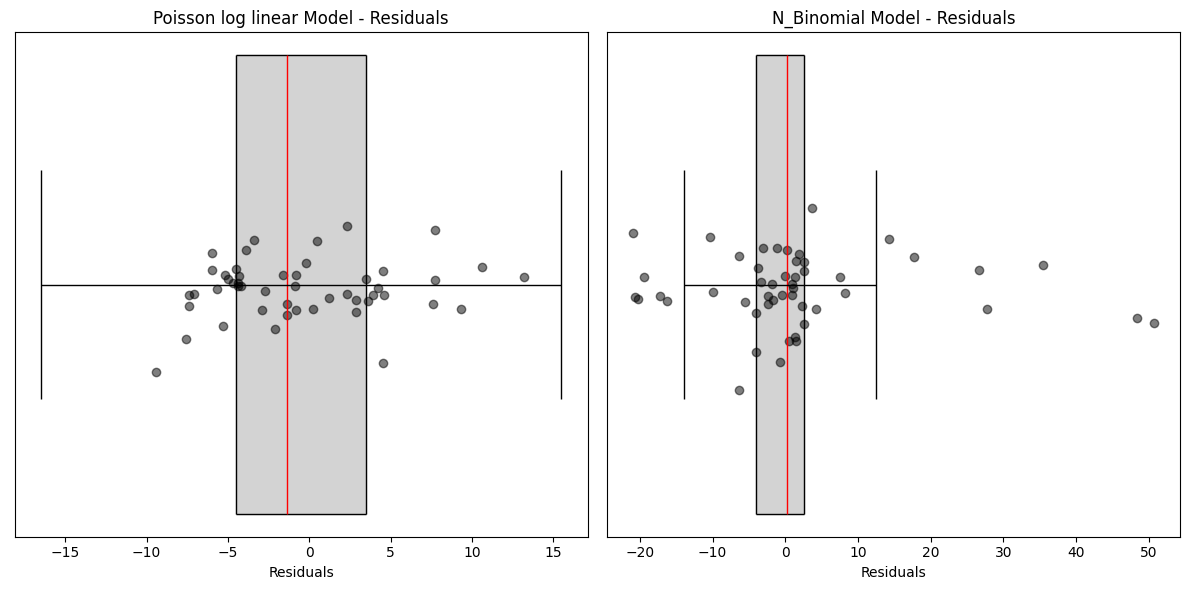

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

custom_boxplot(poisson_flatten, inner_percentage=50, ax=axes[0])
axes[0].set_xlabel('Residuals')
axes[0].set_title('Poisson log linear Model - Residuals')

custom_boxplot(n_Binomial_flatten, inner_percentage=50, ax=axes[1])
axes[1].set_xlabel('Residuals')
axes[1].set_title('N_Binomial Model - Residuals')

plt.tight_layout()
plt.show()

# 4 different Residuals

In [6]:
poisson_residuals = poisson_results.resid_response, poisson_results.resid_deviance, poisson_results.resid_pearson, poisson_results.resid_pearson

neg_binomial_residuals = neg_binomial_results.resid_response, neg_binomial_results.resid_deviance, neg_binomial_results.resid_pearson, neg_binomial_results.resid_pearson

names=["Response Residual:","Deviance Residual:","Pearson Residual:","Deleted Residual:"]

# boxplots of 4 residuals

# Outliers marked in contingency table as per deifferent residuals

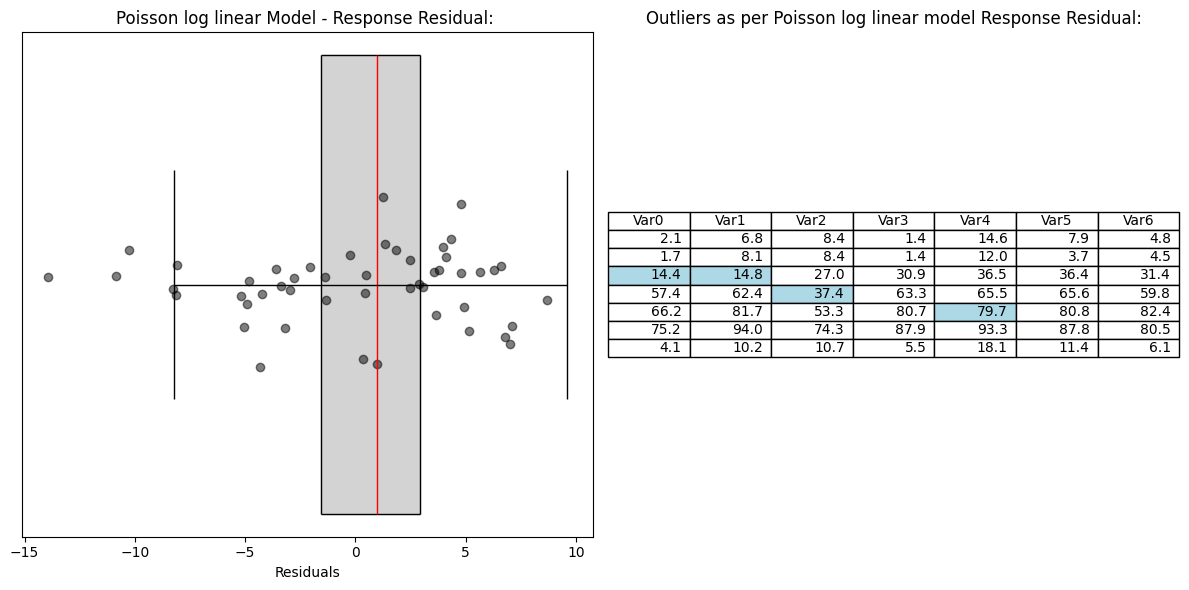

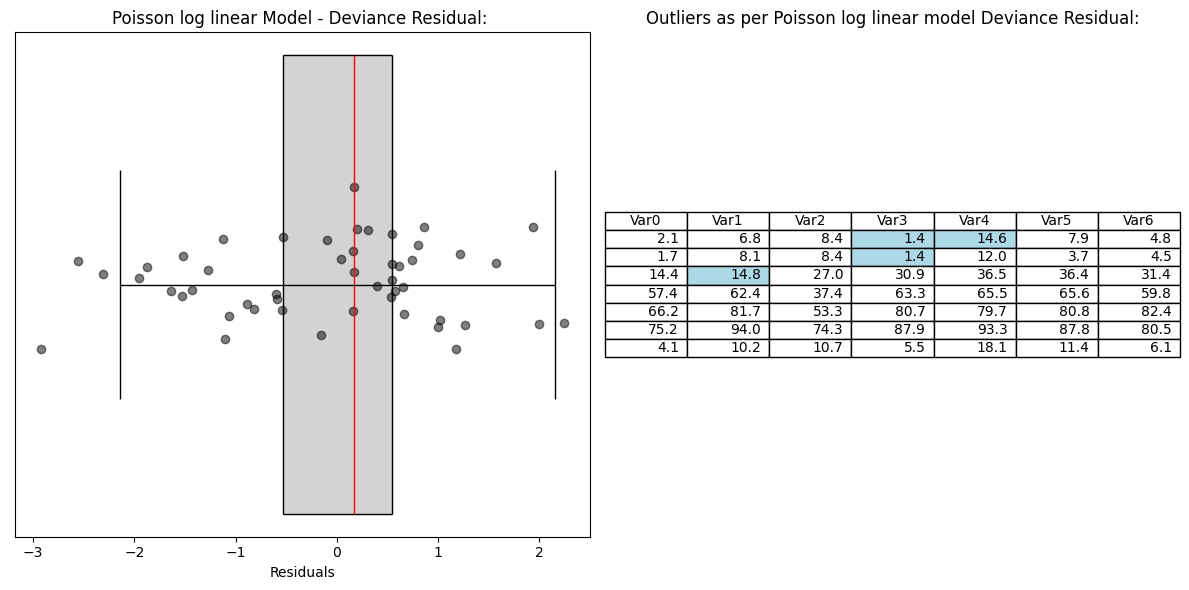

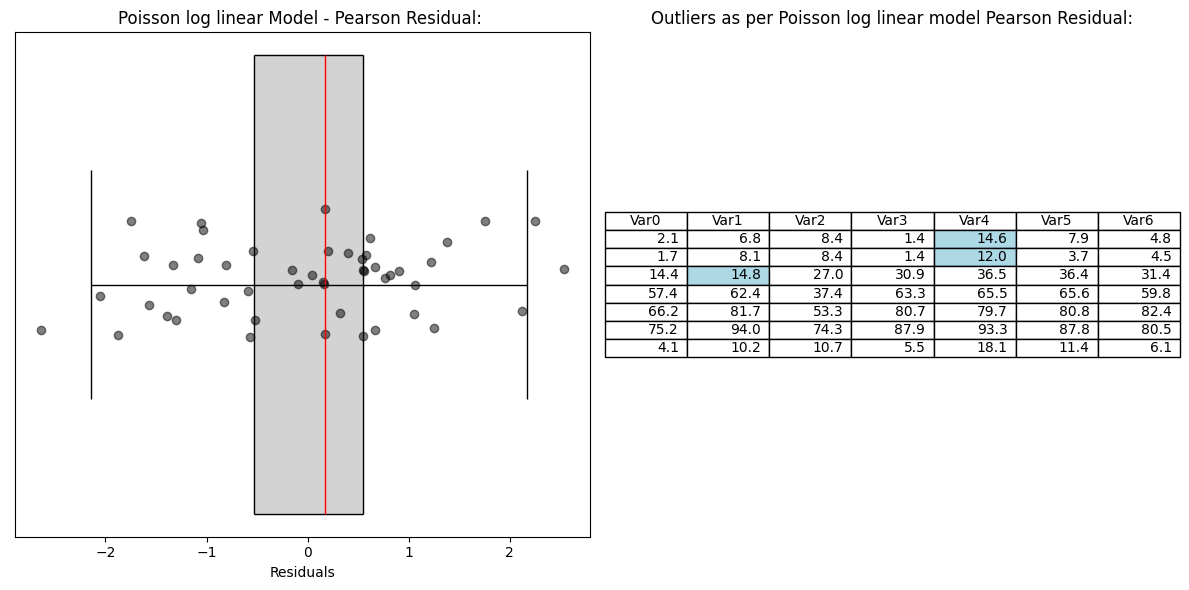

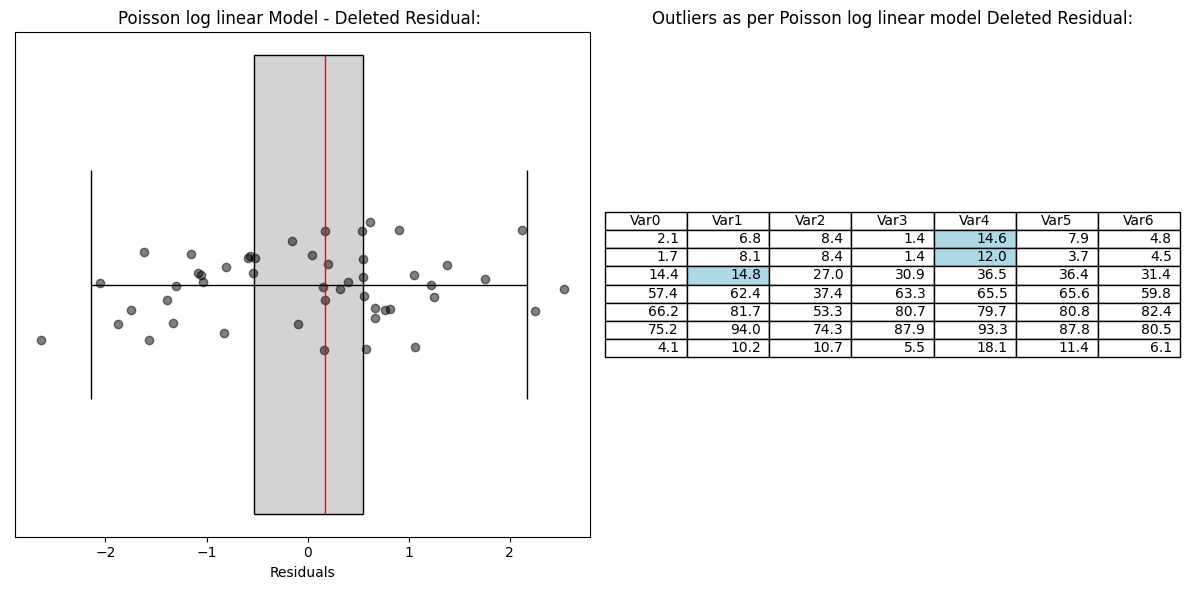

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def is_outlier(value, q1, q3):
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (value < lower_bound) or (value > upper_bound)



for i in range(4):
    flat_residuals = poisson_residuals[i]

    q1 = np.percentile(flat_residuals, 37)
    q3 = np.percentile(flat_residuals, 63)

    outliers = np.array([is_outlier(value, q1, q3) for value in flat_residuals])

    outliers_matrix = outliers.reshape(contingency_table.shape)


    df_table = pd.DataFrame(contingency_table, columns=[f'Var{j}' for j in range(outliers_matrix.shape[1])])

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    custom_boxplot(flat_residuals, inner_percentage=26, ax=axes[0])
    axes[0].set_xlabel('Residuals')
    axes[0].set_title(f"Poisson log linear Model - {names[i]} ")

    axes[1].table(cellText=df_table.values.astype(str),
                colLabels=df_table.columns,
                cellColours=np.where(outliers_matrix, 'lightblue', 'white'),
                loc='center')
    axes[1].axis('off')
    axes[1].set_title(f"Outliers as per Poisson log linear model {names[i]}")

    plt.tight_layout()
    plt.show()